In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split

In [3]:
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

In [4]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [5]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df

,Filepath,Label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE
...,...,...
39995,../input/surface-crack-detection/Positive/0854...,POSITIVE
39996,../input/surface-crack-detection/Negative/1944...,NEGATIVE
39997,../input/surface-crack-detection/Positive/0977...,POSITIVE
39998,../input/surface-crack-detection/Positive/1504...,POSITIVE


In [6]:
train_df, test_df = train_test_split(df,train_size=0.7,shuffle=True,random_state=42)

In [7]:
train_df.shape

(28000, 2)

In [8]:
test_df.shape

(12000, 2)

**Image Data Generator generates batches of tensor image data with real-time data augmentation.**

**For more insights check the tensorflow official documentation https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator**

In [9]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

**flow_from_dataframe checks the path available on the dataframe and then automatically search for the image in train directory. Then it make the desired preprocessing steps available in ImageDataGenerator**

**More insights can be found from this article https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1**

In [10]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training')

Found 22400 validated image filenames belonging to 2 classes.


In [11]:
val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation')

Found 5600 validated image filenames belonging to 2 classes.


In [12]:
test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42)

Found 12000 validated image filenames belonging to 2 classes.


**Training the model**

In [13]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33    

**Fitting the model**

In [14]:
history = model.fit(train_data,validation_data=val_data,epochs=10,
            callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True)])

Epoch 1/10
700/700 [==============================] - 210s 296ms/step - loss: 0.5894 - accuracy: 0.6901 - val_loss: 0.2327 - val_accuracy: 0.9420
Epoch 2/10
700/700 [==============================] - 51s 72ms/step - loss: 0.1870 - accuracy: 0.9489 - val_loss: 0.1266 - val_accuracy: 0.9607
Epoch 3/10
700/700 [==============================] - 46s 65ms/step - loss: 0.1068 - accuracy: 0.9687 - val_loss: 0.1029 - val_accuracy: 0.9780
Epoch 4/10
700/700 [==============================] - 48s 68ms/step - loss: 0.0780 - accuracy: 0.9767 - val_loss: 0.1036 - val_accuracy: 0.9764
Epoch 5/10
700/700 [==============================] - 59s 85ms/step - loss: 0.0777 - accuracy: 0.9769 - val_loss: 0.0804 - val_accuracy: 0.9702
Epoch 6/10
700/700 [==============================] - 74s 106ms/step - loss: 0.0665 - accuracy: 0.9790 - val_loss: 0.0652 - val_accuracy: 0.9793
Epoch 7/10
700/700 [==============================] - 47s 68ms/step - loss: 0.0639 - accuracy: 0.9804 - val_loss: 0.0733 - val_accura

**At the end of 10th epoch we are getting an accuracy of 0.9793 and validation accuracy of 0.9759**

In [15]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time")
fig.show()

In [16]:
fig = px.line(
    history.history,
    y=['accuracy', 'val_accuracy'],
    labels={'index': "Epoch", 'value': "Accuracy"},
    title="Training and Validation Accuracy Over Time")
fig.show()

In [17]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

In [18]:
evaluate_model(model, test_data)

    Test Loss: 0.05720
Test Accuracy: 97.91%


**Test accuracy is 97.91% and Test loss is 0.05720**

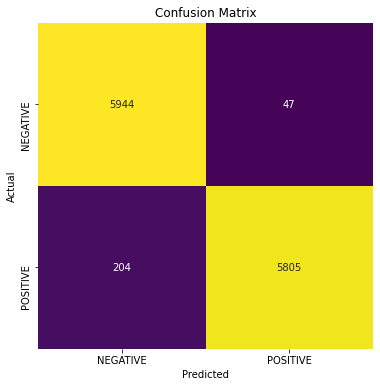

In [20]:
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
cm = confusion_matrix(test_data.labels, y_pred)
clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='viridis', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**We got 11749 correct predictions out of 12000 records in test set.**

In [21]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98      5991
    POSITIVE       0.99      0.97      0.98      6009

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000

